In [1]:
from Bio import SeqIO
from collections import Counter
import pandas as pd 
import re
import requests
import json
import time
import glob
import pprint
import seaborn as sns
import pylab as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import pycountry 
import pycountry_convert as pc
pp = pprint.PrettyPrinter()
import numpy as np
from tabulate import tabulate
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import regex as re
import plotly.graph_objects as go
import os

from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import nltk
from bs4 import BeautifulSoup


 

stemmer=SnowballStemmer("english")
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

import networkx as nx
from collections import defaultdict
from itertools import combinations

from fa2_modified import ForceAtlas2
from community import community_louvain
from operator import itemgetter
from graspologic.utils import is_symmetric
from graspologic.partition import leiden, modularity

import textmining
  

%env folder = X:\5_Research\Paul\dsi_origins\

env: folder=X:\5_Research\Paul\dsi_origins\


In [2]:
path = %env folder

In [123]:
# Load the GEXF file
G = nx.read_gexf(path+R'processed_data/co_word_network_+2tfidf_backbone_90.gexf')


In [124]:
components = nx.connected_components(G)
num_components = nx.number_connected_components(G)

# Get the largest connected component
largest_component = max(components, key=len)

G_mc = G.subgraph(largest_component)

In [125]:
num_components

2

In [157]:
resolutions = []
community_nrs = []
modularity_scores = []
seed_nrs = []

for loop_nr in list(range(1,11,1)):  
    for resolution in [x/10 for x in list(range(5, 21,1))]:
        leiden_partition_map = leiden(G_mc, resolution=resolution, random_seed = loop_nr)
        community_nr = len(set(leiden_partition_map.values()))
        modularity_score = modularity(G_mc, leiden_partition_map)
        print(f"Resolution: {resolution}, Modularity: {modularity_score}, Nr of communities: {community_nr}, Seed nr: {loop_nr}")
        resolutions.append(resolution)
        community_nrs.append(community_nr)
        modularity_scores.append(modularity_score)
        seed_nrs.append(loop_nr)
        
    

Resolution: 0.5, Modularity: 1.3041457659365892e-05, Nr of communities: 3, Seed nr: 1
Resolution: 0.6, Modularity: 0.29527120253103883, Nr of communities: 3, Seed nr: 1
Resolution: 0.7, Modularity: 0.30199964328335616, Nr of communities: 3, Seed nr: 1
Resolution: 0.8, Modularity: 0.31012766588275437, Nr of communities: 8, Seed nr: 1
Resolution: 0.9, Modularity: 0.3128152374853686, Nr of communities: 12, Seed nr: 1
Resolution: 1.0, Modularity: 0.31431965778515547, Nr of communities: 11, Seed nr: 1
Resolution: 1.1, Modularity: 0.31095815705947366, Nr of communities: 12, Seed nr: 1
Resolution: 1.2, Modularity: 0.3074194767742987, Nr of communities: 15, Seed nr: 1
Resolution: 1.3, Modularity: 0.30303314192248587, Nr of communities: 20, Seed nr: 1
Resolution: 1.4, Modularity: 0.3010511411664328, Nr of communities: 23, Seed nr: 1
Resolution: 1.5, Modularity: 0.2925828070721868, Nr of communities: 27, Seed nr: 1
Resolution: 1.6, Modularity: 0.286840592954347, Nr of communities: 30, Seed nr: 1

In [159]:
leiden_results = pd.DataFrame(zip(resolutions,community_nrs,modularity_scores, seed_nrs), columns = ['resolution', 'nr_communities', 'modularity', 'seed'])
leiden_results_grouped = leiden_results.groupby(['resolution']).mean().rename(columns = {'nr_communities':'nr_communities_av', 'modularity': 'modularity_av'}).drop(columns = ['seed'])
leiden_results_grouped['modularity_std'] = leiden_results.groupby(['resolution']).std()['modularity']
leiden_results_grouped['nr_communities_std'] = leiden_results.groupby(['resolution']).std()['nr_communities']
leiden_results_grouped

nr_communities_av  modularity_av  modularity_std  \
resolution                                                     
0.5                       4.1       0.000057        0.000122   
0.6                       4.4       0.261181        0.056053   
0.7                       5.6       0.291217        0.022608   
0.8                       7.4       0.306522        0.010106   
0.9                      10.0       0.312799        0.006441   
1.0                       9.8       0.316547        0.005307   
1.1                      11.3       0.315839        0.002653   
1.2                      14.4       0.309941        0.002301   
1.3                      18.2       0.304761        0.001752   
1.4                      20.8       0.298475        0.001852   
1.5                      25.7       0.292086        0.002144   
1.6                      29.3       0.286307        0.001995   
1.7                      32.5       0.281753        0.001770   
1.8                      39.4       0.275901        0.002157   
1.9                      43.8       0.270516        0.002664   
2.0                      50.5       0.264481        0.001963   

            nr_communities_std  
resolution                      
0.5                   3.314949  
0.6                   1.712698  
0.7                   2.674987  
0.8                   1.349897  
0.9                   1.699673  
1.0                   0.918937  
1.1                   1.337494  
1.2                   1.955050  
1.3                   1.686548  
1.4                   1.398412  
1.5                   1.636392  
1.6                   2.057507  
1.7                   1.900292  
1.8                   2.065591  
1.9                   2.043961  
2.0                   2.321398

In [171]:
#export best modularity version of resolution 0.7 
resolution = 0.6
seed = 8
leiden_partition_map = leiden(G_mc, resolution=resolution, random_seed = seed) # picking one of the seeds from the table above
community_nr = len(set(leiden_partition_map.values()))
modularity_score = modularity(G_mc, leiden_partition_map)
print(f"Resolution: {resolution}, Modularity: {modularity_score}, Nr of communities: {community_nr}, Seed nr: {seed}")


#Add the community information to nodes
for node, community in leiden_partition_map.items():
    G_mc.nodes[node]['community_small_res'] = community

#calculate weighted degree and add to G_mc
for node, weighted_degree in dict(G_mc.degree(weight='weight')).items():
    G_mc.nodes[node]['weighted_degree'] = weighted_degree

community_0 = []
community_1 = []
community_2 = []
    
for k,v in nx.get_node_attributes(G_mc, "community_small_res").items():
    if v == 0: 
        community_0.append(k)
    if v == 1: 
        community_1.append(k)
    if v == 2: 
        community_2.append(k)


# calculate within community weighted degrees
G_mc_com0 = G_mc.subgraph(community_0)
G_mc_com1 = G_mc.subgraph(community_1)
G_mc_com2 = G_mc.subgraph(community_2)

#calculate weighted degree and add to G_mc
for node, weighted_degree in dict(G_mc_com0.degree(weight='weight')).items():
    G_mc_com0.nodes[node]['weighted_degree_small_com0'] = weighted_degree

#calculate weighted degree and add to G_mc
for node, weighted_degree in dict(G_mc_com1.degree(weight='weight')).items():
    G_mc_com1.nodes[node]['weighted_degree_small_com1'] = weighted_degree

#calculate weighted degree and add to G_mc
for node, weighted_degree in dict(G_mc_com2.degree(weight='weight')).items():
    G_mc_com2.nodes[node]['weighted_degree_small_com2'] = weighted_degree

Resolution: 0.6, Modularity: 0.2923313739974475, Nr of communities: 4, Seed nr: 8


In [173]:
#export best modularity version of resolution 0.7 
resolution = 0.8
seed = 3
leiden_partition_map = leiden(G_mc, resolution=resolution, random_seed = seed) # picking one of the seeds from the table above
community_nr = len(set(leiden_partition_map.values()))
modularity_score = modularity(G_mc, leiden_partition_map)
print(f"Resolution: {resolution}, Modularity: {modularity_score}, Nr of communities: {community_nr}, Seed nr: {seed}")


#Add the community information to nodes
for node, community in leiden_partition_map.items():
    G_mc.nodes[node]['community_medium_res'] = community

#calculate weighted degree and add to G_mc
for node, weighted_degree in dict(G_mc.degree(weight='weight')).items():
    G_mc.nodes[node]['weighted_degree'] = weighted_degree

community_0 = []
community_1 = []
community_2 = []
community_3 = []
community_4 = []
community_5 = []
community_6 = []

    
for k,v in nx.get_node_attributes(G_mc, "community_medium_res").items():
    if v == 0: 
        community_0.append(k)
    if v == 1: 
        community_1.append(k)
    if v == 2: 
        community_2.append(k)
    if v == 3: 
        community_3.append(k)
    if v == 4: 
        community_4.append(k)
    if v == 5: 
        community_5.append(k)
    if v == 6: 
        community_6.append(k)


# calculate within community weighted degrees
G_mc_com0 = G_mc.subgraph(community_0)
G_mc_com1 = G_mc.subgraph(community_1)
G_mc_com2 = G_mc.subgraph(community_2)
G_mc_com3 = G_mc.subgraph(community_3)
G_mc_com4 = G_mc.subgraph(community_4)
G_mc_com5 = G_mc.subgraph(community_5)
G_mc_com6 = G_mc.subgraph(community_6)


#calculate weighted degree and add to G_mc
for node, weighted_degree in dict(G_mc_com0.degree(weight='weight')).items():
    G_mc_com0.nodes[node]['weighted_degree_medium_com0'] = weighted_degree

#calculate weighted degree and add to G_mc
for node, weighted_degree in dict(G_mc_com1.degree(weight='weight')).items():
    G_mc_com1.nodes[node]['weighted_degree_medium_com1'] = weighted_degree

#calculate weighted degree and add to G_mc
for node, weighted_degree in dict(G_mc_com2.degree(weight='weight')).items():
    G_mc_com2.nodes[node]['weighted_degree_medium_com2'] = weighted_degree

for node, weighted_degree in dict(G_mc_com3.degree(weight='weight')).items():
    G_mc_com3.nodes[node]['weighted_degree_medium_com3'] = weighted_degree

for node, weighted_degree in dict(G_mc_com4.degree(weight='weight')).items():
    G_mc_com4.nodes[node]['weighted_degree_medium_com4'] = weighted_degree

for node, weighted_degree in dict(G_mc_com5.degree(weight='weight')).items():
    G_mc_com5.nodes[node]['weighted_degree_medium_com5'] = weighted_degree

for node, weighted_degree in dict(G_mc_com6.degree(weight='weight')).items():
    G_mc_com6.nodes[node]['weighted_degree_medium_com6'] = weighted_degree

Resolution: 0.8, Modularity: 0.312948465932325, Nr of communities: 7, Seed nr: 3


In [175]:
G_mc.nodes['hiv1']

{'label': 'hiv1',
 'community_smaller_res': 0,
 'weighted_degree': 4433.0,
 'weighted_degree_com0': 3870.0,
 'weighted_degree_small_com0': 4035.0,
 'weighted_degree_medium_com1': 3766.0,
 'community_small_res': 0,
 'community_medium_res': 1}

In [177]:
#safe data
nx.write_gexf(G_mc, path+R"processed_data\co_word_network_+2tfidf_backbone_90_leiden_innerweighdeg_small_medium.gexf")

In [178]:
pd.DataFrame.from_dict(dict(G_mc.nodes(data = True)), orient='index').drop(columns = ['label']).to_csv(path+'processed_data/co_word_network_+2tfidf_backbone_90_leiden_innerweighdeg_small_medium.csv')

In [10]:
# Load the GEXF file
#G_mc = nx.read_gexf(path+R'processed_data\co_word_network_+2tfidf_backbone_90_communities_weighdegree.gexf')


In [458]:
# Remove edges among the top 1% and bottom 1% of edge weight logs
edge_weights = [data['weight'] for _, _, data in G_mc.edges(data=True)]
edge_weights_sorted = sorted(edge_weights)
top_threshold = np.percentile(np.array([np.log(x+1) for x in edge_weights]), 90) 
bottom_threshold = np.percentile(np.array([np.log(x+1) for x in edge_weights]), 10) 
filtered_edges = [(u, v) for u, v, data in G_mc.edges(data=True) if bottom_threshold <= np.log(data['weight']+1) <= top_threshold]
G_mc_filtered = G_mc.edge_subgraph(filtered_edges).copy()

# Get the largest connected component
components_filtered = nx.connected_components(G_mc_filtered)

largest_component_filtered = max(components_filtered, key=len)

G_mc_filtered_mc = G_mc_filtered.subgraph(largest_component_filtered)

In [459]:
#safe data
nx.write_gexf(G_mc_filtered_mc, path+R"processed_data\co_word_network_+2tfidf_backbone_90_communities_weighdegree_filt.gexf")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


BarnesHut Approximation  took  3.76  seconds
Repulsion forces  took  65.85  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  0.71  seconds
AdjustSpeedAndApplyForces step  took  0.56  seconds


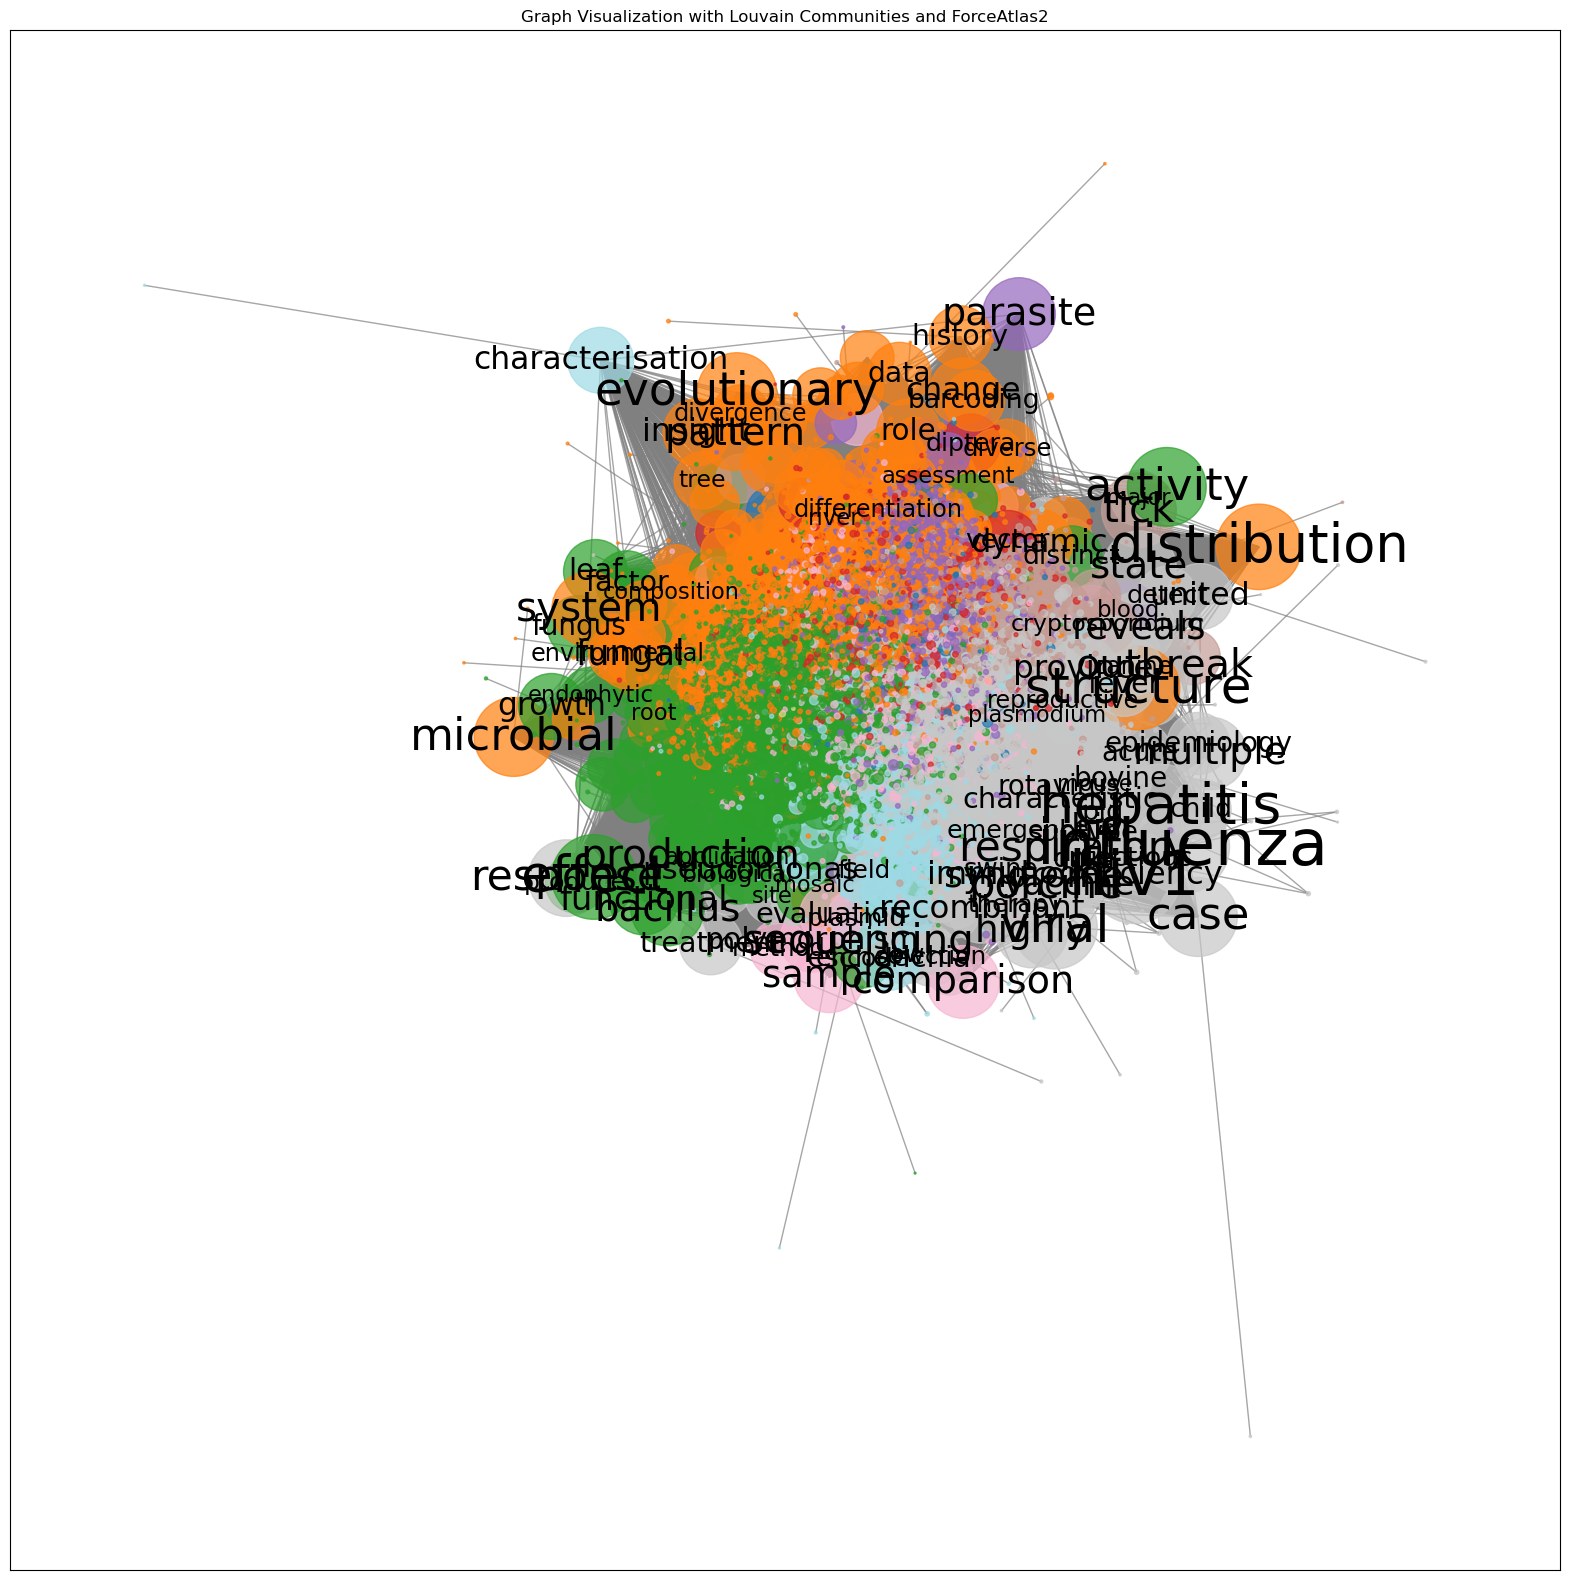

In [525]:
# ForceAtlas2 Visualization
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=50.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)

# Get positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(G_mc, pos=None, iterations=100)

# Calculate weighted degrees
weighted_degrees = dict(G_mc.degree(weight='weight'))

# Scale node sizes based on weighted degree
node_sizes = [weighted_degrees[node] for node in G_mc.nodes()]  # Adjust scaling factor as needed




# Plot the graph
plt.figure(figsize=(20, 20))
node_colors = [communities[node] for node in G_mc_filtered.nodes()]
node_sizes = [weighted_degrees[node] for node in G_mc_filtered.nodes()]

# Find the x nodes with the highest weighted degree
nr_nodes_label_vis = 100
scaling_factor = 100
highest_weighted_degree_nodes = sorted(weighted_degrees.items(), key=itemgetter(1), reverse=True)[:nr_nodes_label_vis]
highest_weighted_degree_labels = {node: node for node, _ in highest_weighted_degree_nodes}
highest_weighted_degree_label_sizes = {}
for k,v in dict(highest_weighted_degree_nodes).items(): 
    highest_weighted_degree_label_sizes[k] = v / scaling_factor

nx.draw_networkx(
    G_mc_filtered,
    pos=positions,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    with_labels=False,
    node_size=node_sizes,
    edge_color='gray',
    alpha=0.7
)

# Add labels for the 20 highest weighted degree nodes with scaled font sizes
for node, label in highest_weighted_degree_labels.items():
    plt.text(
        positions[node][0],
        positions[node][1],
        label,
        fontsize=highest_weighted_degree_label_sizes[node],
        color='black',
        ha='center',
        va='center'
    )

plt.title("Graph Visualization with Louvain Communities and ForceAtlas2")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:24<00:00,  1.24it/s]


BarnesHut Approximation  took  37.99  seconds
Repulsion forces  took  746.28  seconds
Gravitational forces  took  1.45  seconds
Attraction forces  took  7.46  seconds
AdjustSpeedAndApplyForces step  took  6.02  seconds


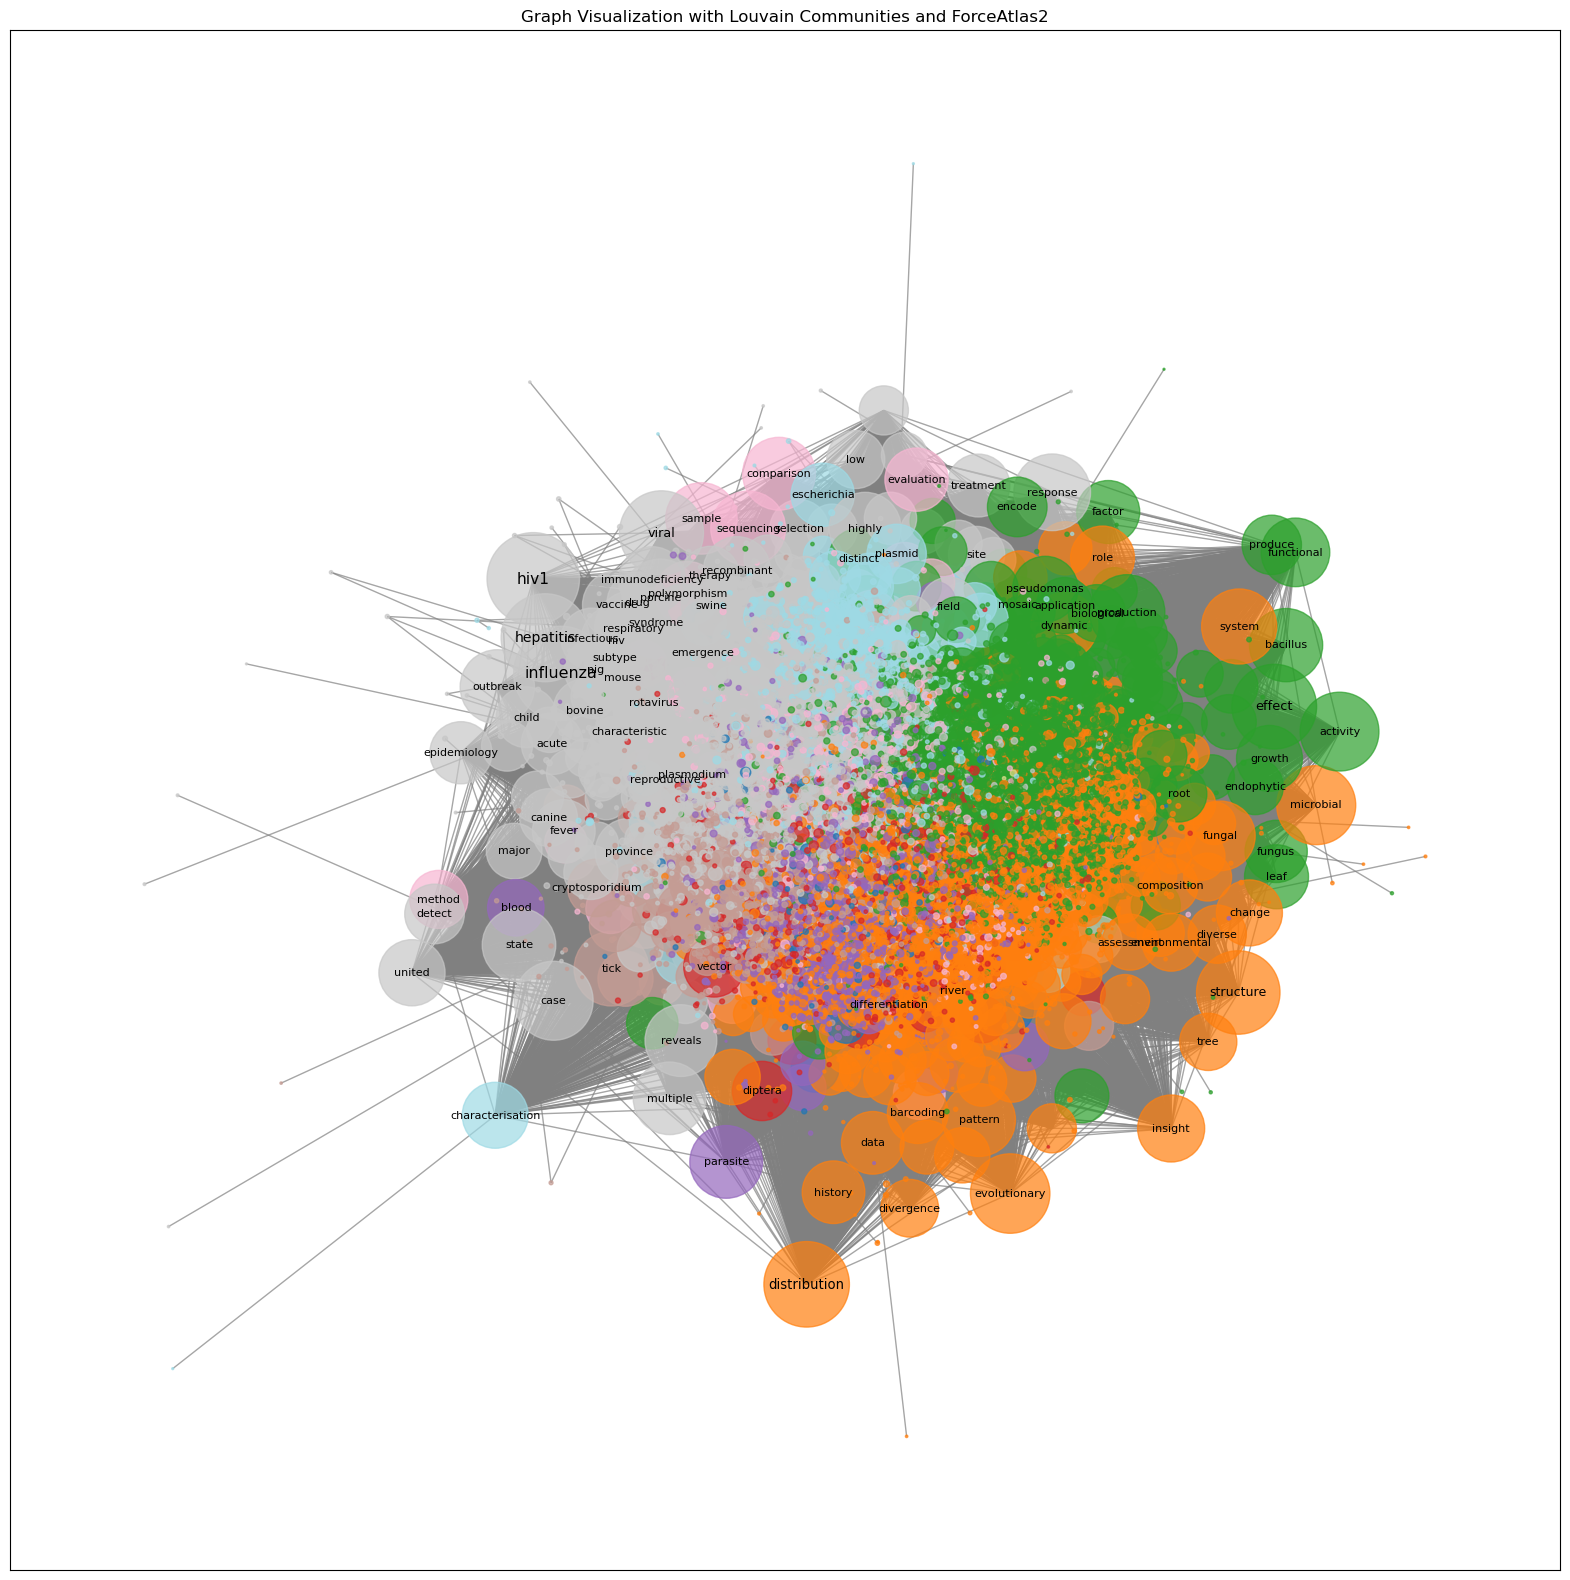

In [533]:
# ForceAtlas2 Visualization
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=50.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)

# Get positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(G_mc, pos=None, iterations=1000)

# Calculate weighted degrees
weighted_degrees = dict(G_mc.degree(weight='weight'))

# Scale node sizes based on weighted degree
node_sizes = [weighted_degrees[node] for node in G_mc.nodes()]  # Adjust scaling factor as needed

# Find the x nodes with the highest weighted degree
nr_nodes_label_vis = 100
highest_weighted_degree_nodes = sorted(weighted_degrees.items(), key=itemgetter(1), reverse=True)[:nr_nodes_label_vis]
highest_weighted_degree_labels = {node: node for node, _ in highest_weighted_degree_nodes}

# Scale label font sizes based on node size for the x highest weighted degree nodes
scaling_factor = 400
label_font_sizes = {node: max(8, min(node_sizes[list(G_mc.nodes()).index(node)] / scaling_factor, nr_nodes_label_vis)) for node in highest_weighted_degree_labels}

# Remove edges among the top 1% and bottom 1% of edge weights
edge_weights = [data['weight'] for _, _, data in G_mc.edges(data=True)]
edge_weights_sorted = sorted(edge_weights)
top_threshold = edge_weights_sorted[int(len(edge_weights) * 0.999)]
bottom_threshold = edge_weights_sorted[int(len(edge_weights) * 0.001)]
filtered_edges = [(u, v) for u, v, data in G_mc.edges(data=True) if bottom_threshold < data['weight'] <= top_threshold]
G_filtered = G_mc.edge_subgraph(filtered_edges).copy()

# Plot the graph
plt.figure(figsize=(20, 20))
node_colors = [partition[node] for node in G_filtered.nodes()]
node_sizes = [weighted_degrees[node] for node in G_filtered.nodes()]

nx.draw_networkx(
    G_filtered,
    pos=positions,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    with_labels=False,
    node_size=node_sizes,
    edge_color='gray',
    alpha=0.7
)

# Add labels for the 20 highest weighted degree nodes with scaled font sizes
for node, label in highest_weighted_degree_labels.items():
    plt.text(
        positions[node][0],
        positions[node][1],
        label,
        fontsize=label_font_sizes[node],
        color='black',
        ha='center',
        va='center'
    )

plt.title("Graph Visualization with Louvain Communities and ForceAtlas2")
plt.show()

In [17]:
G_subgraph = G.subgraph(list(G.nodes)[:1000])

In [187]:
components = nx.connected_components(G_subgraph)
num_components = nx.number_connected_components(G_subgraph)

# Get the largest connected component
largest_component = max(components, key=len)

G_subgraph_mc = G_subgraph.subgraph(largest_component)

In [353]:
# Louvain Community Detection
partition = community_louvain.best_partition(G_subgraph_mc, weight='weight', resolution = 1)

# Add the community information to nodes
for node, community in partition.items():
    G_subgraph_mc.nodes[node]['community'] = community


In [354]:
#modularity value
community_louvain.modularity(partition, G_subgraph_mc)

0.34358550644352287

In [355]:
#nr of communities
len(set(partition.values()))

11

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 127.44it/s]


BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.63  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


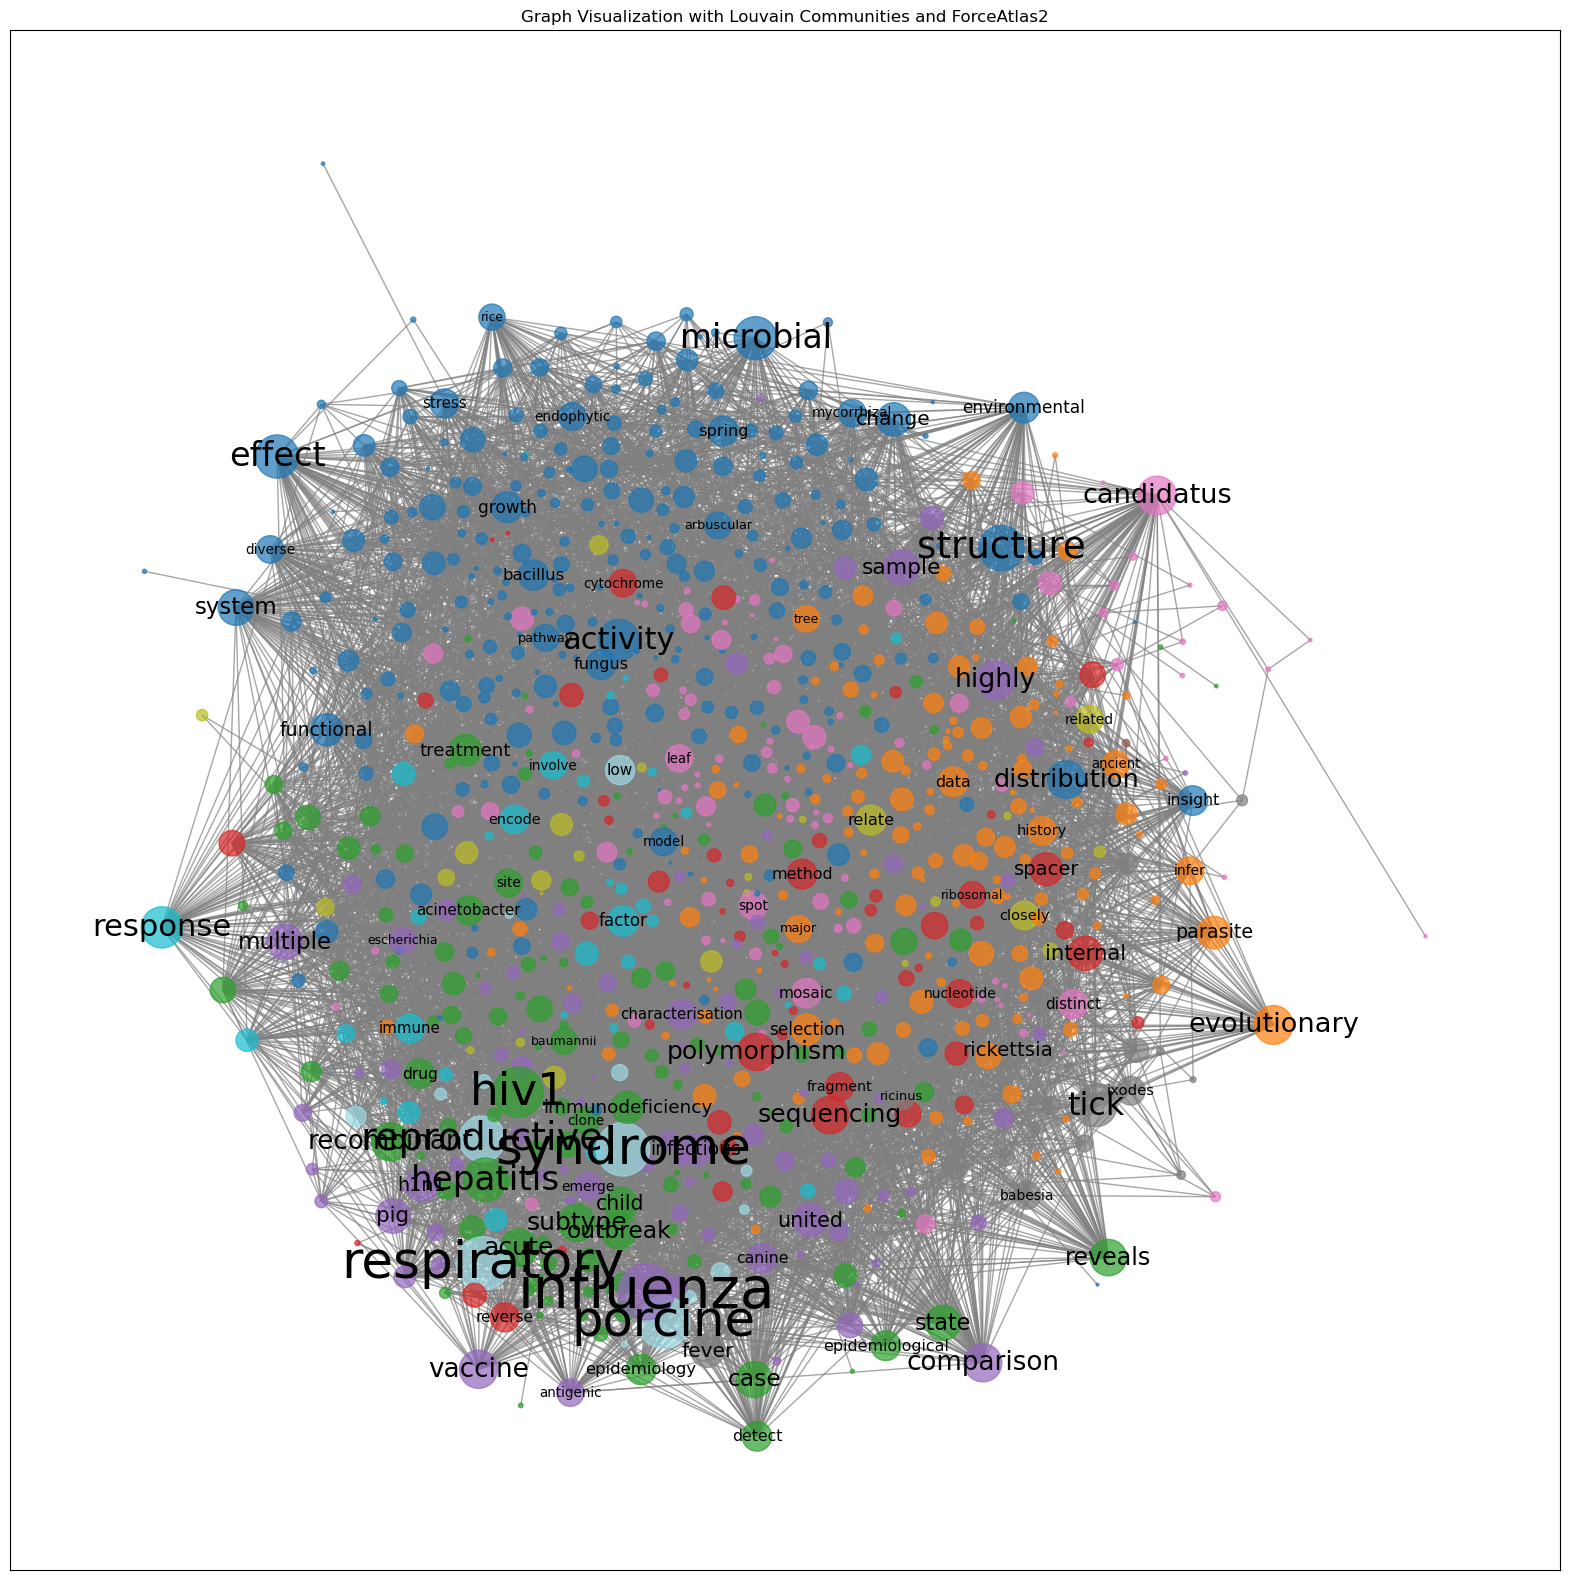

In [441]:
# ForceAtlas2 Visualization
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=50.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)

# Get positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(G_subgraph_mc, pos=None, iterations=10)

# Calculate weighted degrees
weighted_degrees = dict(G_subgraph_mc.degree(weight='weight'))

# Scale node sizes based on weighted degree
node_sizes = [weighted_degrees[node] for node in G_subgraph_mc.nodes()]  # Adjust scaling factor as needed

# Find the x nodes with the highest weighted degree
nr_nodes_label_vis = 100
highest_weighted_degree_nodes = sorted(weighted_degrees.items(), key=itemgetter(1), reverse=True)[:nr_nodes_label_vis]
highest_weighted_degree_labels = {node: node for node, _ in highest_weighted_degree_nodes}

# Scale label font sizes based on node size for the x highest weighted degree nodes
scaling_factor = 40
label_font_sizes = {node: max(8, min(node_sizes[list(G_subgraph_mc.nodes()).index(node)] / scaling_factor, nr_nodes_label_vis)) for node in highest_weighted_degree_labels}

# Remove edges among the top 1% and bottom 1% of edge weights
edge_weights = [data['weight'] for _, _, data in G_subgraph_mc.edges(data=True)]
edge_weights_sorted = sorted(edge_weights)
top_threshold = edge_weights_sorted[int(len(edge_weights) * 0.90)]
bottom_threshold = edge_weights_sorted[int(len(edge_weights) * 0.10)]
filtered_edges = [(u, v) for u, v, data in G_subgraph_mc.edges(data=True) if bottom_threshold < data['weight'] <= top_threshold]
G_filtered = G_subgraph_mc.edge_subgraph(filtered_edges).copy()

# Plot the graph
plt.figure(figsize=(20, 20))
node_colors = [partition[node] for node in G_filtered.nodes()]
node_sizes = [weighted_degrees[node] for node in G_filtered.nodes()]

nx.draw_networkx(
    G_filtered,
    pos=positions,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    with_labels=False,
    node_size=node_sizes,
    edge_color='gray',
    alpha=0.7
)

# Add labels for the 20 highest weighted degree nodes with scaled font sizes
for node, label in highest_weighted_degree_labels.items():
    plt.text(
        positions[node][0],
        positions[node][1],
        label,
        fontsize=label_font_sizes[node],
        color='black',
        ha='center',
        va='center'
    )

plt.title("Graph Visualization with Louvain Communities and ForceAtlas2")
plt.show()

In [ ]:
#trash

In [ ]:
louvain_results_grouped

In [ ]:
resolutions = []
community_nrs = []
modularity_scores = []
seed_nrs = []

for loop_nr in list(range(1,11,1)):  
    for resolution in [x/10 for x in list(range(6, 16,1))]:
        communities = nx.community.louvain_communities(G_mc, weight='weight', resolution=resolution, seed = loop_nr)
        community_nr = len(communities)
        modularity_score = nx.community.modularity(G_mc, communities, weight='weight')
        print(f"Resolution: {resolution}, Modularity: {modularity_score}, Nr of communities: {community_nr}, Seed nr: {loop_nr}")
        resolutions.append(resolution)
        community_nrs.append(community_nr)
        modularity_scores.append(modularity_score)
        seed_nrs.append(loop_nr)
    

In [444]:
louvain_results = pd.DataFrame(zip(resolutions,community_nrs,modularity_scores, seed_nrs), columns = ['resolution', 'nr_communities', 'modularity', 'seed'])


In [445]:
louvain_results_grouped = louvain_results.groupby(['resolution']).mean().rename(columns = {'nr_communities':'nr_communities_av', 'modularity': 'modularity_av'}).drop(columns = ['seed'])

In [446]:
louvain_results_grouped['modularity_std'] = louvain_results.groupby(['resolution']).std()['modularity']
louvain_results_grouped['nr_communities_std'] = louvain_results.groupby(['resolution']).std()['nr_communities']

In [372]:
louvain_results_grouped

nr_communities_av  modularity_av  modularity_std  \
resolution                                                     
0.6                       5.0       0.267132        0.029871   
0.7                       8.8       0.284676        0.025052   
0.8                       9.3       0.302972        0.014945   
0.9                      11.1       0.312890        0.008136   
1.0                      12.5       0.317896        0.002000   
1.1                      11.7       0.312729        0.002761   
1.2                      15.2       0.308082        0.002410   
1.3                      18.2       0.301336        0.002215   
1.4                      22.8       0.295668        0.003614   
1.5                      26.1       0.290364        0.003389   

            nr_communities_std  
resolution                      
0.6                   2.403701  
0.7                   4.289522  
0.8                   1.766981  
0.9                   1.728840  
1.0                   1.269296  
1.1                   1.059350  
1.2                   1.316561  
1.3                   1.751190  
1.4                   1.032796  
1.5                   1.100505